In [1]:
import sys
import socket

sys.path.extend(['/home/jorg/repo/seg_uncertainty'])

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import torch
import os
import glob

from datasets.region_detection.create_detector_dataset import create_dataset
from utils.detection.batch_handler import BatchHandler
from plotting.color_maps import transparent_cmap
from networks.detection.general_setup import config_detector
from utils.detection.froc import compute_detection_performance
from eval_detection.evaluate_model import EvaluationHandler


mycmap = transparent_cmap(plt.get_cmap('plasma'))

# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/model_evaluation"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Ready")

Ready


In [2]:
from datasets.ACDC.detection.load_result_objects import load_results

seg_models = ['drn_mc_ce', 'drn_mc_dice', 'dcnn_mc_brier', 'dcnn_mc_dice', 'unet_mc_ce', 'unet_mc_dice']
io_channels = ['emap', 'bmap']

# seg_models = ['dcnn_mc_brier']
# io_channels = ['emap', 'bmap']

result_dict = {}
result_dict.update((seg_model, {input_channel: {} for input_channel in io_channels}) for seg_model in seg_models)

data_root_dir = os.path.expanduser("~/expers/redo_expers/")

for seg_model in seg_models:
    for input_channels in io_channels:
        model_tag = "{} ({})".format(seg_model, input_channels)
        src_data_path = data_root_dir + seg_model + "/dt_results/"
        results = load_results(src_data_path, input_channels)
        slice_sensitivity, slice_precision, slice_fp_rate, slice_fp, \
        region_sensitivity, region_precision, region_fp_rate, region_fp, detection_rate, thresholds = \
        compute_detection_performance(results, nbr_of_thresholds=40, range_threshold=[0, 1.])
        result_dict[seg_model][input_channels] = \
        {"slice_sensitivity": slice_sensitivity, "slice_precision": slice_precision,
             "slice_fp_rate": slice_fp_rate, "slice_fp": slice_fp, "region_sensitivity": region_sensitivity,
             "region_precision": region_precision, "region_fp_rate": region_fp_rate, "region_fp": region_fp,
             "detection_rate": detection_rate, "thresholds": thresholds}

print(result_dict.keys())


INFO - Successfully loaded 100 patients results from /home/jorg/expers/redo_expers/drn_mc_ce/dt_results/emap
Average % of slices with errors 39.49
Average #regions/volume 1863.96
INFO - Successfully loaded 100 patients results from /home/jorg/expers/redo_expers/drn_mc_ce/dt_results/bmap
Average % of slices with errors 39.39
Average #regions/volume 1863.96
INFO - Successfully loaded 100 patients results from /home/jorg/expers/redo_expers/drn_mc_dice/dt_results/emap
Average % of slices with errors 34.87
Average #regions/volume 1863.96
INFO - Successfully loaded 100 patients results from /home/jorg/expers/redo_expers/drn_mc_dice/dt_results/bmap
Average % of slices with errors 33.73
Average #regions/volume 1863.96
INFO - Successfully loaded 100 patients results from /home/jorg/expers/redo_expers/dcnn_mc_brier/dt_results/emap
Average % of slices with errors 53.69
Average #regions/volume 1863.96
INFO - Successfully loaded 100 patients results from /home/jorg/expers/redo_expers/dcnn_mc_brier/

In [38]:

model_filter = ['unet_mc_ce', 'unet_mc_dice', 'dcnn_mc_brier', 'dcnn_mc_dice']
filtered_result_dict = {}
for f_model in model_filter:
    filtered_result_dict[f_model] = {}
    for umap, results in result_dict[f_model].items():
        filtered_result_dict[f_model][umap] = results
            

INFO - Successfully saved fig /home/jorg/expers/redo_expers/figures/all_models_slices_prec_recall.pdf


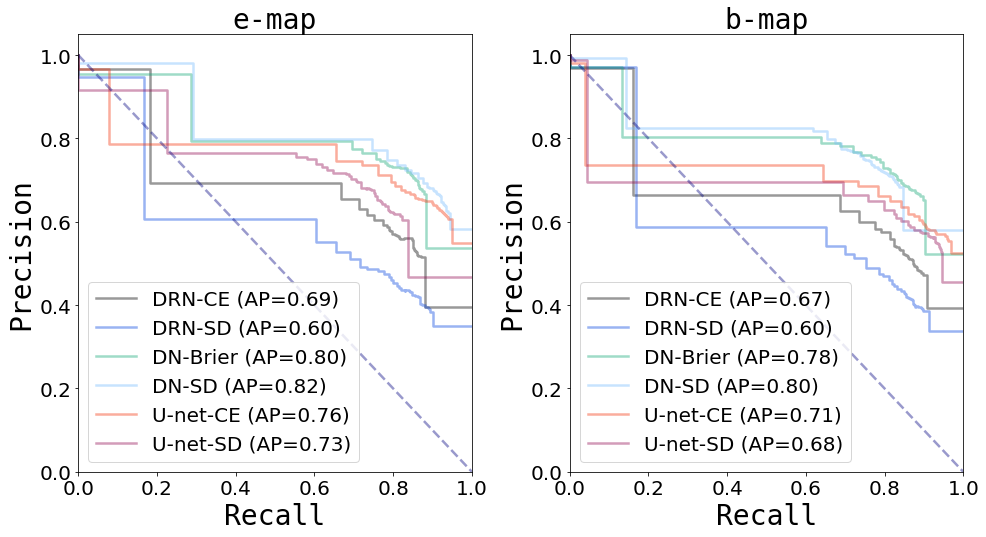

In [5]:
from plotting.compare_detection_models import compare_pr_rec_curves

file_prefix = "all_models"  # -".join(list(result_dict.keys()))
x_measure = 'slice_sensitivity'
y_measure = 'slice_precision'
# seg_models = ['dcnn_mc_brier', 'dcnn_mc_dice', 'unet_mc_ce', 'unet_mc_dice']
# io_channels = ['emap', 'bmap']
do_save = True

output_dir =  os.path.expanduser("~/expers/redo_expers/figures/")
compare_pr_rec_curves(result_dict, x_measure, y_measure,
                              file_prefix=file_prefix,
                                  do_show=True, do_save=do_save, width=15, height=15, output_dir=output_dir)

INFO - Successfully saved fig /home/jorg/expers/redo_expers/figures/all_models_froc_voxel_detection_rate.pdf


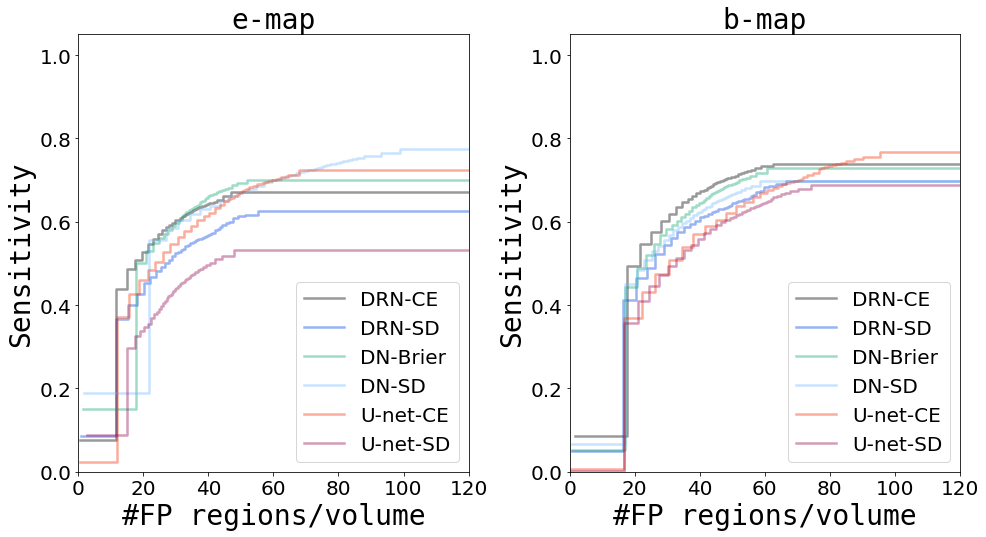

In [7]:
from plotting.compare_detection_models import  compare_froc_curves_dtrate

x_measure = 'region_fp'
y_measure = 'detection_rate'
do_save = True
output_dir =  os.path.expanduser("~/expers/redo_expers/figures/")

compare_froc_curves_dtrate(result_dict, x_measure, y_measure,
                                   file_prefix=file_prefix,
                                   do_show=True, do_save=do_save, width=15, height=15, output_dir=output_dir)

INFO - Successfully saved fig /home/jorg/expers/acdc/figures/all_models_froc_slice_detection.pdf


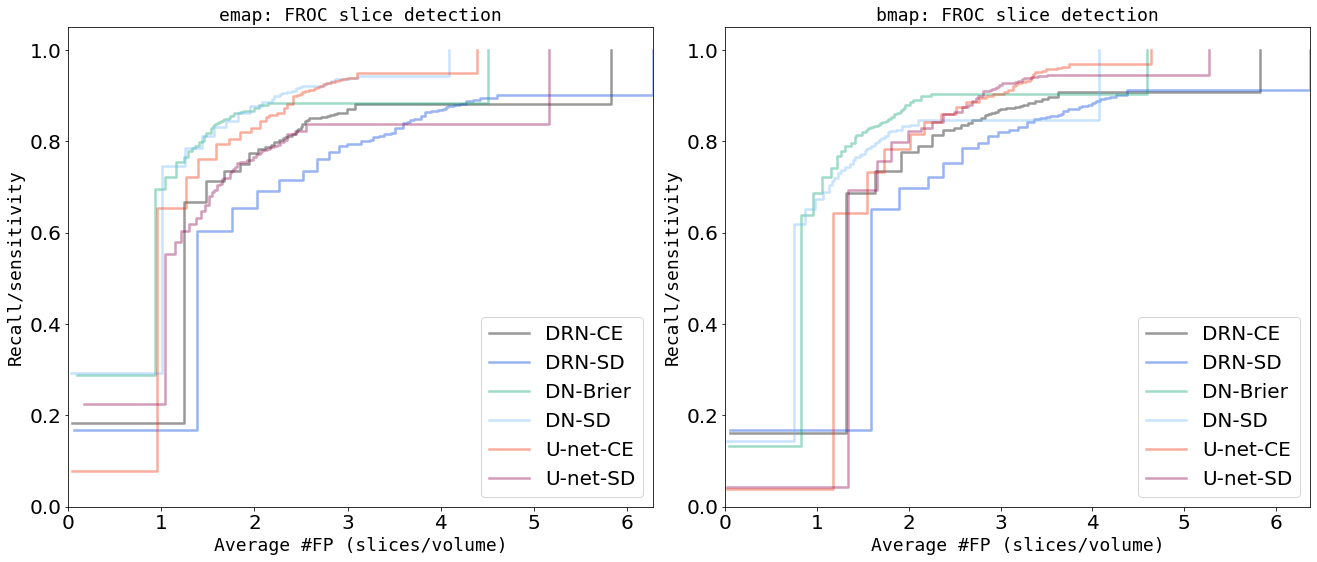

In [11]:
from plotting.compare_detection_models import compare_froc_curves_slices

x_measure = 'slice_fp'
y_measure = 'slice_sensitivity'
do_save = True
output_dir =  os.path.expanduser("~/expers/acdc/figures/")

compare_froc_curves_slices(result_dict, x_measure, y_measure,
                                   file_prefix=file_prefix,
                                   do_show=True, do_save=do_save, width=20, height=16, output_dir=output_dir)